In [10]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn import cross_validation
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [11]:
df = pd.read_excel("data0505.xlsx",header=0)
# clean up data
df = df.dropna(how = 'all')
df = df.fillna(0)
df = df.round(4)
df=df[df['Power']>=0]
df=df[df['SOC']>0]
df=df[df['SOH']>0]
df=df[df['SEI_delta']>0]
df.head()

,SOC,SOH,Power,T,SEI_after,SEI_delta
10,80,1.0,0.0526,23,0.0,44.8776
11,80,1.0,0.1579,23,0.0,46.1896
12,80,1.0,0.2632,23,0.0,47.5605
13,80,1.0,0.3684,23,0.0,48.9998
14,80,1.0,0.4737,23,0.0,50.4819


In [12]:
min_sei = min(df.iloc[:,5])
max_sei = max(df.iloc[:,5])
min_sei
max_sei
range_sei = max_sei-min_sei

# normalizaed
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.head()

,0,1,2,3,4,5
0,1.0,0.0,0.000000,0.0,0.0,0.067068
1,1.0,0.0,0.111146,0.0,0.0,0.153487
2,1.0,0.0,0.222293,0.0,0.0,0.243787
3,1.0,0.0,0.333333,0.0,0.0,0.338592
4,1.0,0.0,0.444480,0.0,0.0,0.436216


In [13]:
x = np.array(df_normalized.iloc[:,0:3])#first three column are SoC, SoH, power
y = np.array(df_normalized.iloc[:,5])#delta SEI
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
x, y, test_size=0.2, random_state=42)
total_len = X_train.shape[0]
total_len

4872

In [14]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Absolute Percentage error: %.4f"
      % np.mean(abs(regr.predict(X_test) - Y_test)/Y_test))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f' % regr.score(X_test, Y_test))

Coefficients: 
 [ 0.022439   -0.04618564  0.68645928]
Absolute Percentage error: 0.0715
Variance score: 0.9897


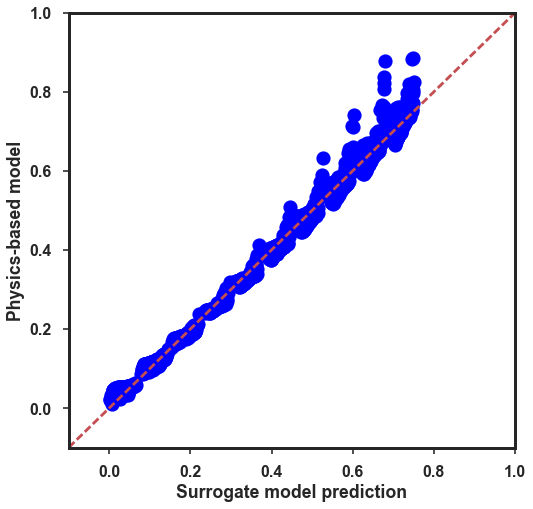

In [57]:

plt.figure(figsize=(8,8))

# Plot outputs
plt.scatter(regr.predict(X_test), Y_test, color='blue',
         linewidth=3)
plt.plot(range(-1,2),range(-1,2),'r--')
plt.ylim([-0.1,1])
plt.xlim([-0.1,1])
plt.xlabel('Surrogate model prediction')
plt.ylabel('Physics-based model')

#plt.savefig('linearY.png',transparent=True, dpi=800)
plt.show()


In [58]:
E = 1; # battery energy
P = 1; # battery power
T = 1800; # 1 hour, resolution 4 seconds
ts = 2/3600;

In [59]:
## Constant instruction signal
soc_arr = [0.2]; #initial SoC 0.2
soh_arr = [10**(-8)]; #initial SoH 1e-8
power_arr = [0.6]; #constant power instruction 0.6
for i in range(T):
    state = [soc_arr[i],soh_arr[i],power_arr[i]]
    state = np.array(state);
    delta_soh = ((regr.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16) #calculate the thickness change
    soh_new = soh_arr[-1]+delta_soh; # new SoH = previous SoH + thickness change
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E #new SoC = previous SoC + energy charged
    soc_arr.append(soc_new)
    power_new = 0.6
    power_arr.append(power_new)

In [60]:
soh_arr=np.array(soh_arr)


In [61]:

#linear = linear.apply(lambda i: ''.join(i))
#df.to_csv('list.csv', index=False)

In [62]:
linear = pd.DataFrame(soh_arr, columns=["delta"])
linear.to_csv('linear.csv')


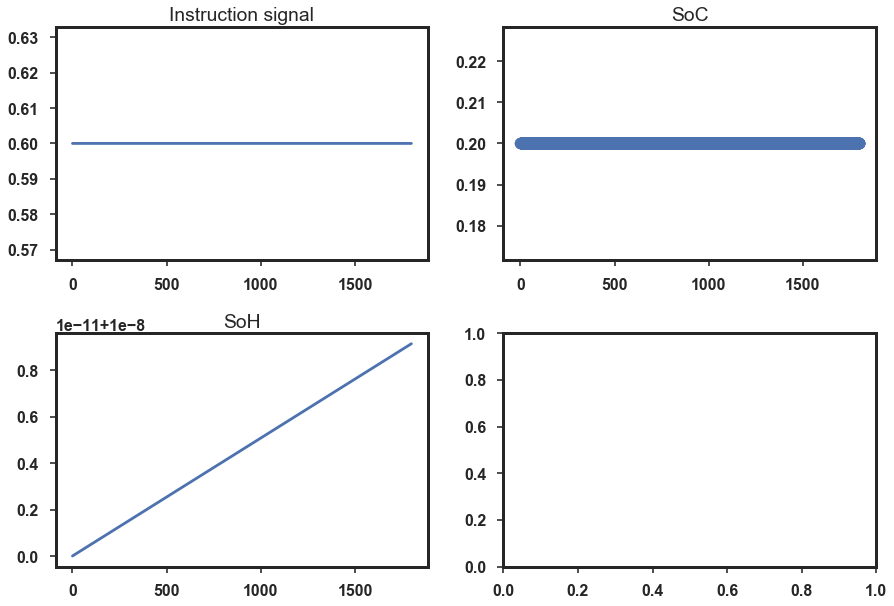

In [63]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(range(T), power_arr[0:T])
axarr[0, 0].set_title('Instruction signal')
#axarr[0, 0].xlabel('Time(s)')
#axarr[0, 0].xticks() 
axarr[0, 1].scatter(range(T), soc_arr[0:T])
axarr[0, 1].set_title('SoC')
axarr[1, 0].plot(range(T), soh_arr[0:T])
axarr[1, 0].set_title('SoH')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()

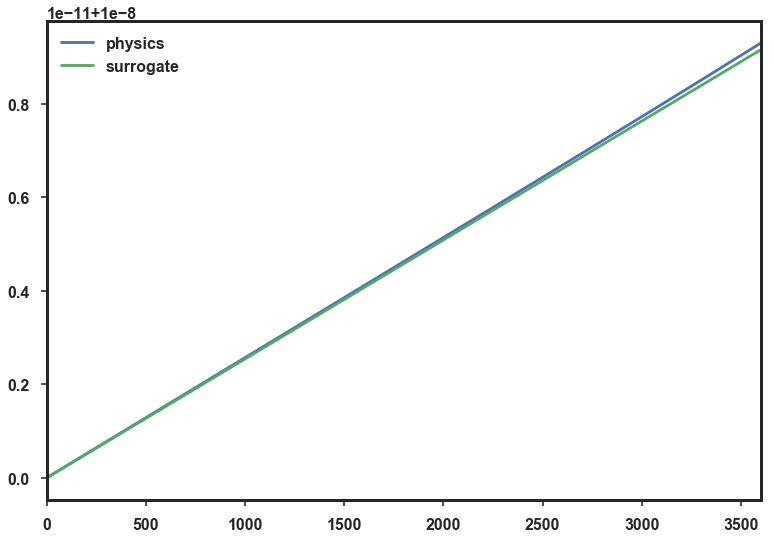

In [44]:
physics=pd.read_csv('20SOC60Power_delta_new.csv',header=None,names=["time","delta"])
plt.plot(physics.time,physics.delta,label="physics")
plt.plot(range(0,3600,2), soh_arr[0:T],label="surrogate")
plt.legend(loc='upper left')
plt.autoscale(False)
#plt.ylim((1e-8, 6*1e-12+1e-8))
#plt.ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e-8))
plt.xlim([0,3600])
plt.show()

In [45]:
## Sine wave instruction signal
soc_arr = [0.6];
soh_arr = [10**(-8)];
power_arr = [0];
for i in range(T):
    if(power_arr[i]>=0):
        state = [soc_arr[i],soh_arr[i],power_arr[i]]
        state = np.array(state);
        delta_soh = ((regr.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16)
    else:
        delta_soh = 0
    soh_new = soh_arr[-1]+delta_soh;
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E
    soc_arr.append(soc_new)
    power_new = np.sin(2*np.pi*(i+1)*2/600)
    power_arr.append(power_new)

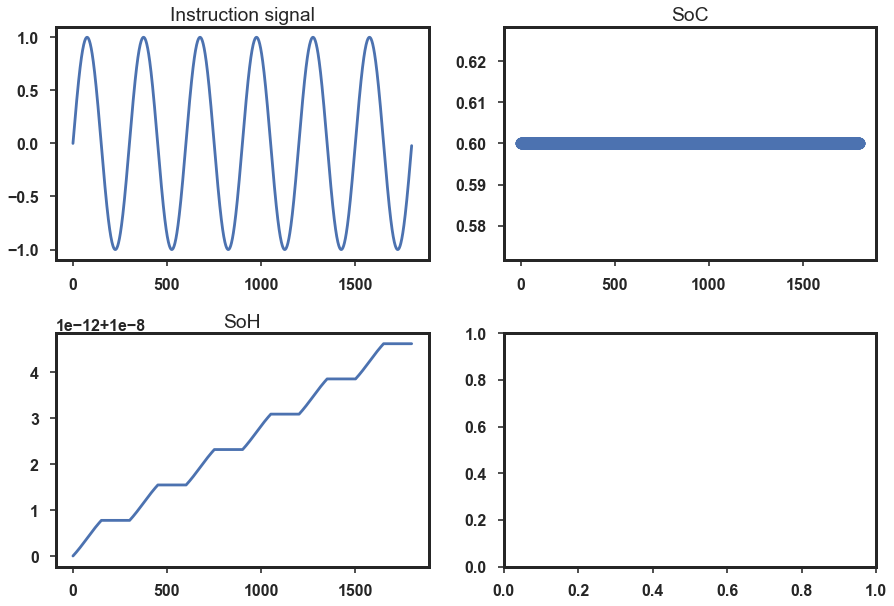

In [46]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(range(T), power_arr[0:T])
axarr[0, 0].set_title('Instruction signal')
axarr[0, 1].scatter(range(T), soc_arr[0:T])
axarr[0, 1].set_title('SoC')
axarr[1, 0].plot(range(T), soh_arr[0:T])
axarr[1, 0].set_title('SoH')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots

In [47]:
soh_arr[-1]

array([  1.00046216e-08])

In [48]:
linear_sine=pd.DataFrame(np.array(soh_arr), columns=["delta"])
linear_sine.to_csv('linear_sine.csv')

In [50]:
linear_sine.to_csv('linear_sine.csv')

In [344]:
sine=pd.read_csv('sin_delta_new.csv',header=None,names=["time","delta"])
sine.delta.tail()

196    1.000399e-08
197    1.000399e-08
198    1.000399e-08
199    1.000399e-08
200    1.000399e-08
Name: delta, dtype: float64

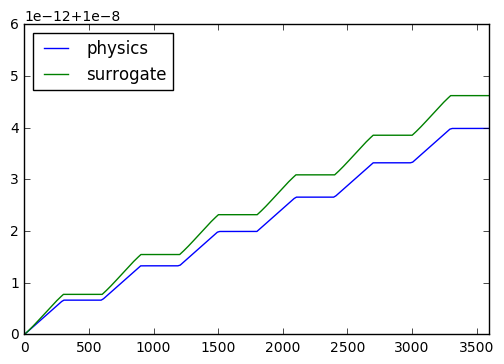

In [345]:
plt.plot(sine.time,sine.delta,label="physics")
plt.plot(range(0,3600,2), soh_arr[0:T],label="surrogate")
plt.legend(loc='upper left')
plt.autoscale(False)
plt.ylim((1e-8, 6*1e-12+1e-8))
#plt.ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e-8))
plt.xlim([0,3600])
plt.show()